# Run knn / umap for large data on gpu

In [1]:
%load_ext autoreload
%autoreload 2

If you are using fasrc, make sure to run this if it's the first time you run it. 

```
echo "/n/holylfs05/LABS/buenrostro_lab/Lab/gpu_umap" >> ~/.conda/environments.txt
```

Also, make sure you select this environment as your ipykernel when running the code below.

Prepare the following input file:
- a matrix file size of number of cells x number of pcs/topics, save as txt file. No cell name, no columns name, no "" wrapping around numbers, numbers separated with space " ". Just a plain text.
- If you do it otherwise, make sure to edit the `np.loadtxt` command below to reflect that. 
- please do a dimension reduction first to save some runtime. 

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # using the first gpu, for most cases, you wouldn't need to change it. 

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata
import cupy as cp
import cupyx as cpx
import time
import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData
from tqdm.auto import tqdm, trange
import warnings
warnings.filterwarnings("ignore")
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=True, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm_cupy_allocator)

In [4]:
n_neighbors=25
x = np.loadtxt("/data/rzhang/andrew_umap/peakmatrix.txt.gz",delimiter=' ')

In [5]:
x.shape

(200, 334477)

somehow the matrix output by R is transposed: n_topics x n_cells, so you would want to transpose that

In [6]:
x = x.T

create anndata (python version of seurat), using these reduced dim features, transfer it to GPU

In [7]:
adata = anndata.AnnData(X=x)
rsc.utils.anndata_to_GPU(adata)

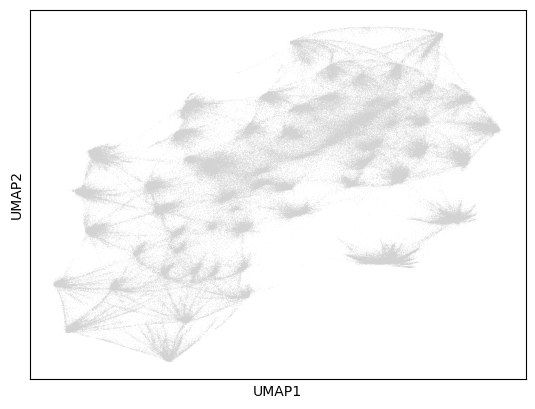

In [8]:
# adjust your n_neighbors, metric, here
rsc.pp.neighbors(adata, metric='cosine', n_neighbors=n_neighbors)
# adjust your min_dist here
rsc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, ncols=1)

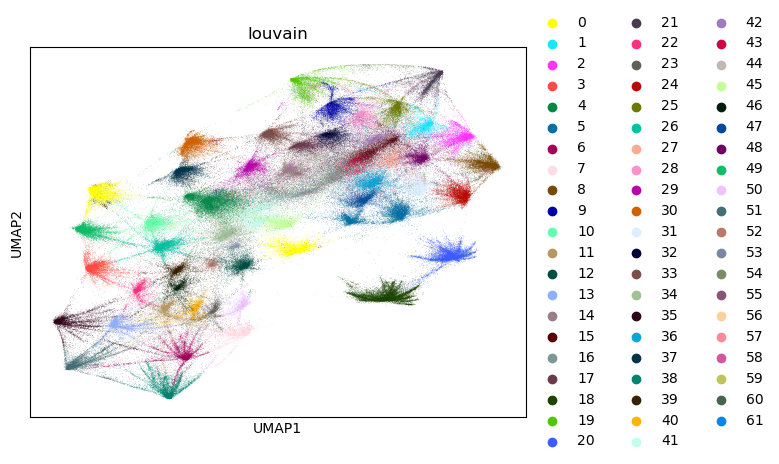

In [9]:
rsc.tl.louvain(adata, resolution=1)
# rsc.tl.leiden(adata, resolution=1) # there is also a leiden option, 
#but it has some error and has not been fixed, don't use it!
sc.pl.umap(adata, ncols=1, color=['louvain'])

In [10]:
# now save it
adata.obs['umap_x'] = adata.obsm['X_umap'][:, 0]
adata.obs['umap_y'] = adata.obsm['X_umap'][:, 1]

In [11]:
# This stores umap coord into tsv format. 
adata.obs.to_csv("./umapcoor_leiden.txt", sep='\t', index=False)

In [ ]:
import scipy.io as sio
# Write the distance & connectivities sparse matrix into sparse.mtx format (R can read it, no worries~)
# But these two are large! Only store them when necessary
sio.mmwrite("./distances.mtx",adata.obsp['distances'])
sio.mmwrite("./connectivities.mtx",adata.obsp['connectivities'])


In [27]:
# Finally, if you just want a row x n_neighbor table, this will achieve it.
coo_matrix = adata.obsp['distances'].tocoo()
row = coo_matrix.row
col = coo_matrix.col
mtx = [[] for i in range(len(adata))]
for r,c in zip(tqdm(row), col):
    mtx[r].append(c)
    
mtx = np.array(mtx)
mtx.shape

  0%|          | 0/8361925 [00:00<?, ?it/s]

(334477, 25)

In [29]:
mtx = pd.DataFrame(mtx)
mtx.to_csv("knn.txt", sep='\t', index=False)